# Demonstration of validation testing with NetworkUnit by replicating the results in Gutzen et al. (2018)
This notebook showcases the basic validation workflow of [NetworkUnit](https://github.com/INM-6/NetworkUnit) based on the functionality provided by the [SciUnit](https://github.com/scidash/sciunit) package. A detailed explanation of the validation workflow and the corresponding tests can be found in *Gutzen et al. (2018) Reproducible neural network simulations: statistical methods for model validation on the level of network activity data, Frontiers in Neuroinformatics, 2018*.



Requirements (Python 2.7.14):

        elephant == 0.5.0
        sciunit == 0.2.0.2
        jupyter == 1.0.0
        tabulate == 0.8.2
        networkx == 2.1
        fastcluster == 1.1.24
        seaborn == 0.8.1

## Table of Contents
- [Setup](#setup)
1. [Polychrony model class](#poly_model)
1. [Iteration I](#it1)
    - [Define model classes](#model1)
    1. [Define test classes and how to perform a test](#test1)
    1. [Visualization](#viz)
    1. [Analysis of spike train cross-correlation](#xcor)
1. [Iteration II](#it2)
    - [Define model classes](#model2)
    1. [Perform validation tests and average over network states](#test2)
1. [Iteration III](#it3)
    - [Define model classes](#model3)
    1. [Define additional test classes](#test3)
    1. [Perform validation tests and average over network states](#test3_avg)
    1. [Comparing the correlation structure](#test3_struct)
    1. [Calculating the power spectrum](#test3_power)    

## Setup <a id='setup'></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import sciunit
import elephant
import numpy as np
from quantities import ms
from neo.core import SpikeTrain
from copy import copy

### Load a version of NetworkUnit (only required once)

In [2]:
%%capture
!git clone -n https://github.com/INM-6/NetworkUnit.git

In [3]:
%%capture
cd NetworkUnit

In [4]:
%%capture
!git checkout 'c92a5a20c504acd6799324291a2b33f26c394b9c' # latest commit at time of paper submission 
!git fetch; git pull

In [5]:
%%capture
cd ..

In [6]:
sys.path.insert(0, './NetworkUnit')

from networkunit import tests, scores, plots, models

In [7]:
data_path = './simulation_data/'

## Define the polychronization model class<a id='poly_model'></a>
NetworkUnit does not yet have an interface to HPC resources or SpiNNaker to perform the simulations automatically. Therefore, the outcomes of manually performed simulations are loaded into the model class.

In [8]:
class polychrony_data(models.spiketrain_data):
    file_path = '' # to be added in child class
    
    params = {'align_to_0': True,
              'filter_inh': True,
             }
    
    def load(self, file_path, simulator, t_start=0, t_stop=60000, filter_inh=False, **kwargs):
        f = open(file_path, 'r')
        lines = f.readlines()
        
        N = 1000 # neurons 
        
        # Read Spike Times
        spike_times = [[]] * N
        for line in lines:
            sec, msec, n = line.split(' ')[:3]
            t = float(sec)*1000. + float(msec)
            n = int(n)
            if t > t_stop:
                break
            spike_times[n] = spike_times[n] + [t]

        # Fill Spike Trains
        nbr_neurons = N
        if filter_inh:
            nbr_neurons = 800
            
        spiketrains = [[]] * nbr_neurons

        for n, st in enumerate(spike_times):
            if n < 800:
                n_type = 'exc'
            else:
                n_type = 'inh'
            if not filter_inh or n_type == 'exc':
                spiketrains[n] = SpikeTrain(np.sort(st), units='ms', 
                                            t_start=t_start, t_stop=t_stop,
                                            n_type=n_type, unitID=n)
        return spiketrains

## Iteration I<a id='it1'></a>

### Define the model instances<a id='model1'></a>

In [9]:
class C_sim(polychrony_data):
    file_path = data_path + 'iteration_I/60s_simulation_runs/C/out_firings_after5h.dat'
    params = copy(polychrony_data.params)
    params.update(color='#2173a3', simulator='C')
    
class S_sim_i(polychrony_data):
    file_path = data_path + 'iteration_I/60s_simulation_runs/SpiNNaker_i/out_firings_after5h.dat'
    params = copy(polychrony_data.params)
    params.update(color='#77b74a', simulator='SpiNNaker')

class S_sim_ii(polychrony_data):
    file_path = data_path + 'iteration_I/60s_simulation_runs/SpiNNaker_ii/out_firings_after5h.dat'
    params = copy(polychrony_data.params)
    params.update(color='#77b74a', simulator='SpiNNaker')
    
class S_sim_iii(polychrony_data):
    file_path = data_path + 'iteration_I/60s_simulation_runs/SpiNNaker_iii/out_firings_after5h.dat'
    params = copy(polychrony_data.params)
    params.update(color='#77b74a', simulator='SpiNNaker')

In [10]:
C = C_sim(name='C')
S_sims = [S_sim_i(name='SpiNNaker (i)'), S_sim_ii(name='SpiNNaker (ii)'), S_sim_iii(name='SpiNNaker (iii)')]

### Show rasterplots

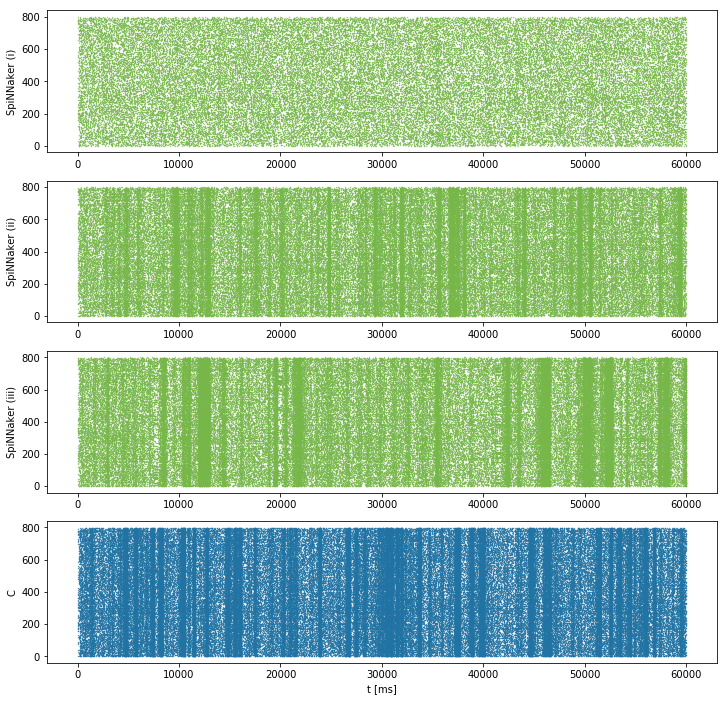

In [11]:
fig, ax = plt.subplots(nrows=4, figsize=(12,12))

for sim_count, sim in enumerate(S_sims + [C]):
    sim.produce_spiketrains()
    for st_count, st in enumerate(sim.spiketrains):
        ax[sim_count].scatter(st, [st_count]*len(st), color=sim.params['color'], marker='.', s=.5)
    ax[sim_count].set_ylabel(sim.name)
ax[-1].set_xlabel('t [ms]');

### Define test classes<a id='test1'></a>
The abstract base classes for these tests are implemented in NetworkUnit so that here only the parameters have to be set and the test is paired with a score class. To perfom a hypothesis test the `effect_size` score can be replaced for example with the `ks_distance` or the `mwu_statistic`.
The inhereted `TestM2M` class adapts the test such that the tests don't need to be initialized with experimental data. 

In [12]:
class FR_test_class(sciunit.TestM2M, tests.firing_rate_test):
    score_type = scores.effect_size # ks_distance, mwu_statistic, students_t

class LV_test_class(sciunit.TestM2M, tests.isi_variation_test):
    score_type = scores.effect_size
    params = {'variation_measure': 'lv'}

class CC_test_class(sciunit.TestM2M, tests.correlation_dist_test):
    score_type = scores.effect_size
    params = {'binsize': 2*ms}

FR_test = FR_test_class()
LV_test = LV_test_class()
CC_test = CC_test_class()

rate_score = [0] * 3
isi_score = [0] * 3
cc_score = [0] * 3

### How to generate the test prediction
This section calculates and returns the firing rates for the loaded spike trains.

In [13]:
FR_test.generate_prediction(C);

#### How to generate the test score
The validation test is performed by calling the judge function, which
    1. checks if the model has all the required capabilities. If a model  
       does not, and skip_incapable=False, then a CapabilityError is raised.
    2. calls generate_prediction() to generate a prediction.
    3. calls compute_score() to generate a score.
    4. checks that the score is of score_type, else raising an InvalidScoreError.
    5. equips the score with metadata:
       a) a reference to the model
       b) a reference to the test.
       c) a reference to the prediction
       d) a reference to the observation
       e) custom metadata defined in bind_score()
    6. returns the score.
    
A model-to-model test (`TestM2M`), requires a list of two or more model classes to be passed to the judge function. The resulting scores are returned in a `pandas.Dataframe`. Individual entries can be accessed via `.iloc[ , ]`

In [14]:
print(FR_test.judge([C, S_sims[0]]).iloc[0,1])



Effect Size
	datasize: 800 	 800
	Effect Size = 3.410 	 CI = (3.257, 3.564)




/home/robin/anaconda3/envs/py37/lib/python3.7/site-packages/sciunit/scores/collections_m2m.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.models = models


#### Comparing multiple models at once

In [15]:
FR_scores = FR_test.judge([C,S_sims[0],S_sims[1],S_sims[2]])
FR_scores.score

/home/robin/anaconda3/envs/py37/lib/python3.7/site-packages/sciunit/scores/collections_m2m.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.models = models


C  SpiNNaker (i)  SpiNNaker (ii)  SpiNNaker (iii)
C                0.000000       3.410068        1.338312         0.902216
SpiNNaker (i)    3.410068       0.000000        2.461155         2.046497
SpiNNaker (ii)   1.338312       2.461155        0.000000         0.258701
SpiNNaker (iii)  0.902216       2.046497        0.258701         0.000000

#### Accessing the confidence intervals of the effect size scores

In [16]:
for i in range(3):
    print(FR_scores.iloc[0,i+1].CI)

(3.2565046827654136, 3.5636304498213436)
(1.2298829330828251, 1.4467412438496141)
(0.7993455111352421, 1.0050873239331575)


**This process is equivalent for the LV_test and the CC_test.**

### Visualization<a id='viz'></a>
Visualize the prediction with the class function `visualize_samples()`. Note that the execution of this cell takes approximately 10 mins because all necessary analyses are performed prior to visualization.

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


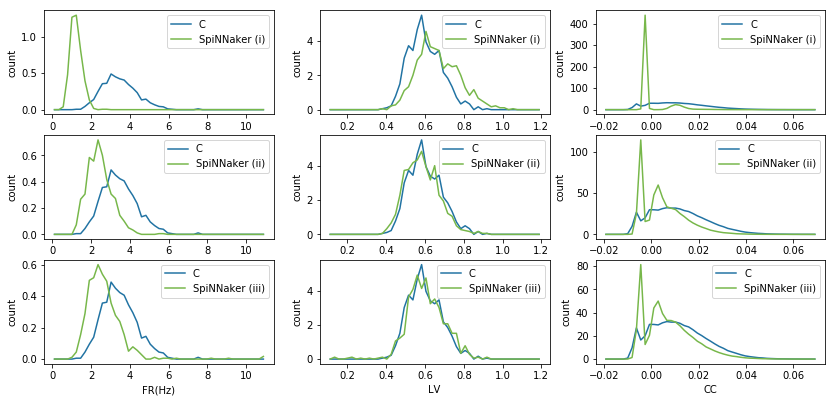

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,6.5))

for test_count, (test, test_name, xlim) in enumerate(zip([FR_test, LV_test, CC_test], 
                                                         ['FR(Hz)', 'LV', 'CC'], 
                                                         [(0,11.), (0.1,1.2), (-0.02, 0.07)])):
    for m_count, S in enumerate(S_sims):
        edges = np.linspace(xlim[0], xlim[1], 50)
        test.visualize_samples(C, S, ax=ax[m_count][test_count], var_name=test_name, 
                               density=False, bins=edges, sample_names=[C.name, S.name])
        ax[m_count][test_count].set_ylabel('count')
        ax[m_count][test_count].legend([C.name, S.name]);

While `visualize_samples()` displays the predictions of the test, `visualize_score()` can visualize the test outcome if the linked score has a plot function.

### Analysis of spike train cross-correlation<a id='xcor'></a>
Define test using the cross-correlation coefficient as correlation measure. This will also lead to the identification of artefacts in the form of *overactive neurons*.

**NOTE: This analysis takes several hours on a standard laptop machine!** It is therefore commented out by default and the reader is invited to continue with [Iteration II](#it2).

In [18]:
# class cross_correlation_struct_test_class(sciunit.TestM2M, tests.generalized_correlation_matrix_test):
#     score_type = scores.eigenangle # not used
#     params = {'binsize': 2*ms,
#               'bin_num': 30000,
#               'maxlag': 50,
#               'cluster_matrix': False,
#               'time_reduction': 'sum'}

# ccc_struct_test = cross_correlation_struct_test_class()

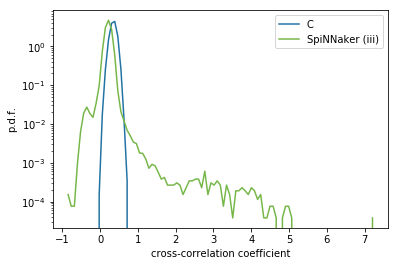

In [19]:
# triu_idx = np.triu_indices(800, 1)
# ax = plots.sample_histogram(ccc_struct_test.generate_prediction(C)[triu_idx[0],triu_idx[1]],
#                             ccc_struct_test.generate_prediction(S_sims[-1])[triu_idx[0],triu_idx[1]],
#                             sample_names=[C.name, S_sims[-1].name], var_name='cross-correlation coefficient',
#                             palette=[C.params['color'], S_sims[-1].params['color']])
# ax.set_yscale('log')
# plt.show()

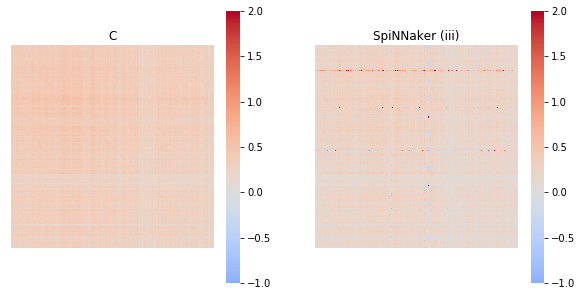

In [20]:
# fig, ax = plt.subplots(ncols=2, figsize=(10,5))

# ccc_struct_test.visualize_samples(C, S_sims[-1], ax=ax, cluster=True, cluster_as=0, limit_to_1=False,
#                                   square=True, cmap='coolwarm', vmax=2, vmin=-1, labels=['']*800)
# ax[0].axis('off')
# ax[1].axis('off')
# plt.show()

#### Identifying the overactive neurons

[ 50 205 240 296 380 420 449 653]


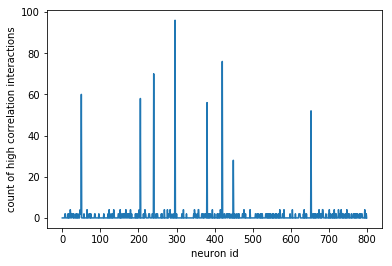

In [21]:
# m = ccc_struct_test.generate_prediction(S_sims[-1]) 
# # threshold 1.5 clearly separates the 'normal' 
# # and the very large correlations (see matrix above)
# hist, edges = np.histogram(np.append(np.where(m > 1.5)[0],np.where(m > 1.5)[1]), bins=np.linspace(0,800,801))
# plt.plot(np.arange(800), hist)
# plt.gca().set_xlabel('neuron id')
# plt.gca().set_ylabel('count of high correlation interactions')
# overactive_neurons = np.where(hist > 20)[0]
# print(overactive_neurons)

## Iteration II<a id='it2'></a>

### Define the model (-instances)<a id='model2'></a>

In [22]:
class C_sim(polychrony_data):
    file_path = data_path + 'iteration_II/60s_simulation_runs/C/'
    params = copy(polychrony_data.params)
    params.update(color='#2173a3', simulator='C')
    
class S_sim(polychrony_data):
    file_path = data_path + 'iteration_II/60s_simulation_runs/SpiNNaker/'
    params = copy(polychrony_data.params)
    params.update(color='#77b74a', simulator='SpiNNaker')
    
# C simulations
class C_1h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after1h.dat'
    params = copy(C_sim.params)
class C_2h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after2h.dat'
    params = copy(C_sim.params)
class C_3h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after3h.dat'
    params = copy(C_sim.params)
class C_4h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after4h.dat'
    params = copy(C_sim.params)
class C_5h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after5h.dat'
    params = copy(C_sim.params)
    
# SpiNNaker simulations
class S_1h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after1h.dat'
    params = copy(S_sim.params)
class S_2h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after2h.dat'
    params = copy(S_sim.params)
class S_3h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after3h.dat'
    params = copy(S_sim.params)
class S_4h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after4h.dat'
    params = copy(S_sim.params)
class S_5h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after5h.dat'
    params = copy(S_sim.params)
    
C_sim_states = [C_1h(name='C 1h'), 
                C_2h(name='C 2h'), 
                C_3h(name='C 3h'), 
                C_4h(name='C 4h'), 
                C_5h(name='C 5h')]
S_sim_states = [S_1h(name='S 1h'), 
                S_2h(name='S 2h'), 
                S_3h(name='S 3h'), 
                S_4h(name='S 4h'), 
                S_5h(name='S 5h')]

### Perform the validation tests and average over the 5 network states<a id='test2'></a>

In [23]:
%%capture
lvs = np.zeros(5)
frs = np.zeros(5)
ccs = np.zeros(5)

for i, (C, S) in enumerate(zip(C_sim_states, S_sim_states)):
    frs[i] = FR_test.judge([C, S]).iloc[0,1].score    
    lvs[i] = LV_test.judge([C, S]).iloc[0,1].score
    ccs[i] = CC_test.judge([C, S]).iloc[0,1].score     

In [24]:
for score in [lvs, frs, ccs]:
    print(np.mean(score), '\t+-\t', np.std(score))

1.2790408154900152 	+-	 0.08639208465277712
0.07736400708339872 	+-	 0.02489887366204492
0.07383260021874113 	+-	 0.005985698846421658


No handles with labels found to put in legend.
No handles with labels found to put in legend.


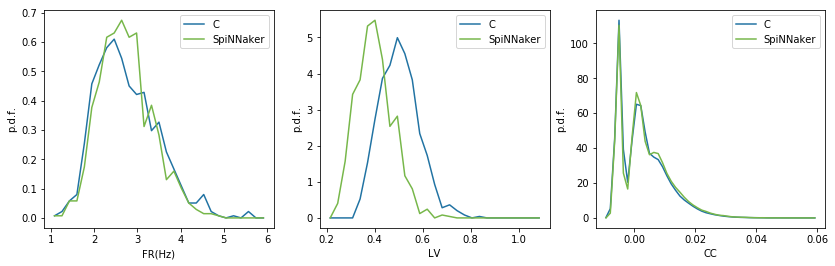

In [25]:
fig, ax = plt.subplots(ncols=3, figsize=(14,4))

for test_count, (test, test_name, xlim, binnum) in enumerate(zip([FR_test, LV_test, CC_test], 
                                                         ['FR(Hz)', 'LV', 'CC'],
                                                         [(1, 6), (0.2, 1.1), (-0.01,0.06)],
                                                         [30, 30, 50])):
    edges = np.linspace(xlim[0], xlim[1], binnum)
    hdl = test.visualize_samples(C_sim_states[-1], S_sim_states[-1], ax=ax[test_count], 
                                 var_name=test_name, bins=edges, density=False)
    ax[test_count].set_ylabel('p.d.f.')
    ax[test_count].legend(['C', 'SpiNNaker'])
plt.show()

## Iteration III<a id='it3'></a>

### Define the model (-instances)<a id='model3'></a>

In [26]:
class C_sim(polychrony_data):
    file_path = data_path + 'iteration_III/60s_simulation_runs/C/'
    params = copy(polychrony_data.params)
    params.update(color='#2173a3', simulator='C')
    
class S_sim(polychrony_data):
    file_path = data_path + 'iteration_III/60s_simulation_runs/SpiNNaker/'
    params = copy(polychrony_data.params)
    params.update(color='#77b74a', simulator='SpiNNaker')
    
# C simulations
class C_1h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after1h.dat'
    params = copy(C_sim.params)
class C_2h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after2h.dat'
    params = copy(C_sim.params)
class C_3h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after3h.dat'
    params = copy(C_sim.params)
class C_4h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after4h.dat'
    params = copy(C_sim.params)
class C_5h(C_sim):
    file_path = C_sim.file_path + 'out_firings_after5h.dat'
    params = copy(C_sim.params)
    
# SpiNNaker simulations
class S_1h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after1h.dat'
    params = copy(S_sim.params)
class S_2h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after2h.dat'
    params = copy(S_sim.params)
class S_3h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after3h.dat'
    params = copy(S_sim.params)
class S_4h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after4h.dat'
    params = copy(S_sim.params)
class S_5h(S_sim):
    file_path = S_sim.file_path + 'out_firings_after5h.dat'
    params = copy(S_sim.params)
    
C_sim_states = [C_1h(name='C 1h'), 
                C_2h(name='C 2h'), 
                C_3h(name='C 3h'), 
                C_4h(name='C 4h'), 
                C_5h(name='C 5h')]
S_sim_states = [S_1h(name='S 1h'), 
                S_2h(name='S 2h'), 
                S_3h(name='S 3h'), 
                S_4h(name='S 4h'), 
                S_5h(name='S 5h')]

### Define additional tests<a id='test3'></a>

In [27]:
class RC_test_class(sciunit.TestM2M, tests.correlation_dist_test):
    score_type = scores.effect_size # scores.mwu_statistic , scores.ks_distance
    params = {'binsize': 100*ms,
                }

class ISI_test_class(sciunit.TestM2M, tests.isi_variation_test):
    score_type = scores.effect_size
    params = {'variation_measure': 'isi',
                }
    
class EW_test_class(sciunit.TestM2M, tests.eigenvalue_test):
    score_type = scores.effect_size
    params = {'binsize': 100*ms,
                }

RC_test = RC_test_class()
ISI_test = ISI_test_class()
EW_test = EW_test_class()

### Perform tests and average over the 5 network states<a id='test3_avg'></a>

In [28]:
%%capture
lvs = np.zeros(5)
frs = np.zeros(5)
ccs = np.zeros(5)
rcs = np.zeros(5)
iss = np.zeros(5)
ews = np.zeros(5)

for i, (C, S) in enumerate(zip(C_sim_states, S_sim_states)):
    lvs[i] = LV_test.judge([C, S]).iloc[0,1].score
    frs[i] = FR_test.judge([C, S]).iloc[0,1].score    
    ccs[i] = CC_test.judge([C, S]).iloc[0,1].score 
    rcs[i] = RC_test.judge([C, S]).iloc[0,1].score
    iss[i] = ISI_test.judge([C, S]).iloc[0,1].score 
    ews[i] = EW_test.judge([C, S]).iloc[0,1].score        

In [29]:
for score in [lvs, frs, ccs, rcs, iss, ews]:
    print(np.mean(score), '\t+-\t', np.std(score))

0.2764334016753339 	+-	 0.09063021176116991
0.4062488110255149 	+-	 0.07918699728819026
0.17338259266127182 	+-	 0.02586885432574671
0.1430740480746116 	+-	 0.024724964924495125
0.13502606221218544 	+-	 0.026772745174304658
6.624726937508733e-17 	+-	 8.114152567456067e-17


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


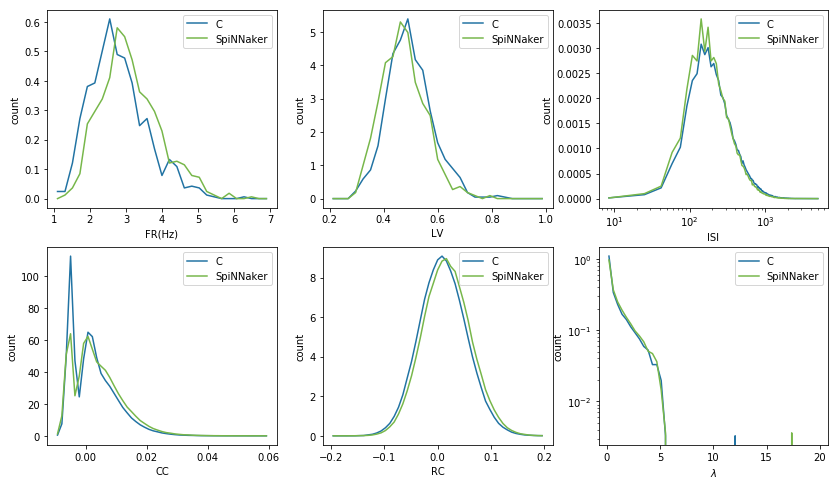

In [30]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(14,8))
ax = np.append(ax[0,:],ax[1,:])

for test_count, (test, test_name, xlim, binnum) in enumerate(zip([FR_test, LV_test, ISI_test, CC_test, RC_test, EW_test], 
                                                         ['FR(Hz)', 'LV', 'ISI', 'CC', 'RC', r'$\lambda$'], 
                                                         [(1, 7), (0.2, 1), (0.2,5000), (-0.01,0.06), (-0.2,0.2), (0,20)],
                                                         [30, 30, 300, 50, 50, 50])):
    edges = np.linspace(xlim[0], xlim[1], binnum)
    test.visualize_samples(C, S, ax=ax[test_count], var_name=test_name, 
                           density=False, bins=edges, sample_names=[C.name, S.name])
    ax[test_count].set_ylabel('count')
    ax[test_count].legend(['C', 'SpiNNaker'])
ax[2].set_xscale('log')
ax[5].set_yscale('log')

### Perform further testing of the correlation structure<a id='test3_struct'></a>

In [31]:
class RC_struct_test_class(sciunit.TestM2M, tests.correlation_matrix_test):
    score_type = scores.eigenangle # not used, replaced manually by the scalar product
    params = {'binsize': 100*ms,
              'bin_num': 600,
              'cluster_matrix': False}
    
RC_struct_test = RC_struct_test_class()

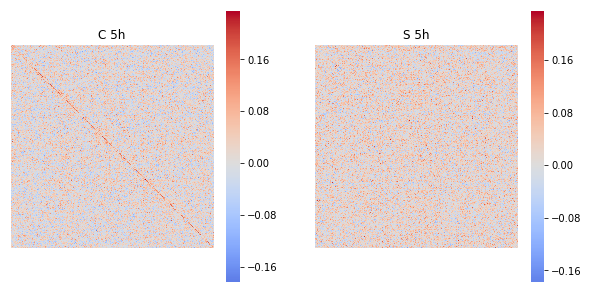

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
RC_struct_test.visualize_samples(C_sim_states[-1], S_sim_states[-1], ax=ax, cluster=True, cluster_as=0, 
                                 cmap='coolwarm', labels=['']*800)
ax[0].axis('off')
ax[1].axis('off')
plt.show()

In [34]:
rc_dot = np.zeros(5)
rc_ref = np.zeros(5)
rc_ref_s = np.zeros(5)

for state in range(5):
    C_rc = RC_struct_test.generate_prediction(C_sim_states[state])[np.triu_indices(800, 1)]
    S_rc = RC_struct_test.generate_prediction(S_sim_states[state])[np.triu_indices(800, 1)]

    rc_dot[state] = np.dot(C_rc, S_rc) / (np.linalg.norm(C_rc) * np.linalg.norm(S_rc))

    N = 10000
    scalar_prod = np.zeros(N)

    for i in range(N):
        idx = np.random.permutation(800)
        S_rc = RC_struct_test.generate_prediction(S_sim_states[state])[idx,:][:,idx]
        S_rc  = S_rc[np.triu_indices(800, 1)]
        scalar_prod[i] = np.dot(C_rc, S_rc) / (np.linalg.norm(C_rc) * np.linalg.norm(S_rc))

    rc_ref[state] = np.mean(scalar_prod)
    rc_ref_s[state] = np.std(scalar_prod)
    print((rc_ref[state] - rc_dot[state]) / rc_ref_s[state])

-45.03832742883313
-43.097819612091776
-44.41413183846407
-45.71720543871651
-44.784543356567056


In [35]:
print('Scalar Products:\t', rc_dot)
print('with Surrogates:\t', rc_ref)
print('Surrogates std :\t', rc_ref_s)

Scalar Products:	 [0.2091862  0.18288254 0.19516047 0.17317861 0.17625249]
with Surrogates:	 [0.10796743 0.09245783 0.09907361 0.08170119 0.08117938]
Surrogates std :	 [0.00224739 0.00209813 0.00216343 0.00200094 0.0021229 ]


### Calculate the power spectrum<a id='test3_power'></a>

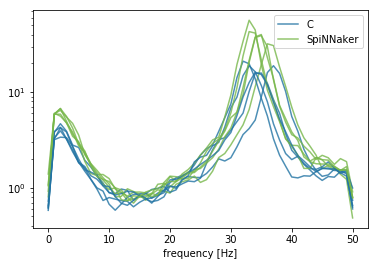

In [36]:
fig, ax = plt.subplots(ncols=1, figsize=(6,4))

for state in range(5):
    for sim_count, sim in enumerate([C_sim_states[state], S_sim_states[state]]):
        sim.produce_spiketrains()
        # Computing the population acitivty with a 100Hz sampling frequency
        asignal = elephant.statistics.time_histogram(sim.spiketrains, binsize=10*ms)
        # Computing the power spectrum using Welch's method
        freqs, power = elephant.spectral.welch_psd(asignal, num_seg=None, len_seg=None, 
                                                   freq_res=1., overlap=0.5, 
                                                   fs=100, window='hanning', nfft=None, detrend='constant', 
                                                   return_onesided=True, scaling='density', axis=-1)
        # Drawing the graph
        ax.plot(freqs, np.squeeze(power), color=sim.params['color'], alpha=0.8)
ax.set_yscale('log')
ax.set_xlabel('frequency [Hz]')
ax.legend(['C', 'SpiNNaker'])

For the results of the SPADE analysis the reader is referred to the folder 'spade_analysis' in this repository.